<a href="https://colab.research.google.com/github/RoFree/1D_FDMethodThermal-EM/blob/main/Thermal_Modeling_of_Coaxial_line_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

The code below implements equations from the paper while also implementing a common FD method 1D temperature solver. The key functions in this library are OneDFiniteThermalSolver which is the 1D FD Thermal solver and OneDFiniteEMLossSolver which uses the FD Thermal Solver to approximate loss on the transmission line (also using the FD method).

[ 1.00000000e+01  8.33333333e+00  6.66716646e+00  5.00000000e+00
  3.33419899e+00  1.66666667e+00  9.99579322e-04 -1.66666667e+00
 -3.33246767e+00 -5.00000000e+00 -6.66616688e+00 -8.33333333e+00
 -1.00000000e+01]


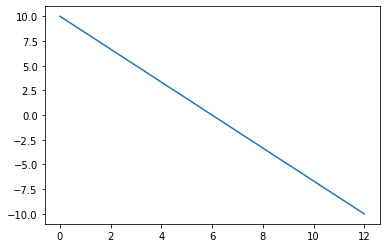

In [ ]:
#thermodynamics utility equations
def R_tCalc(delta_L, t_conduct, areaConduct):
  return delta_L/(t_conduct*areaConduct)

def area_calc(Dout, Dinner):
  return np.pi*pow(Dout/2,2)-np.pi*pow(Dinner/2, 2)


#These functions are depreceated
####################################################################
def HeatFlowInst(Thot, Tcold, R_t):
  return (Thot-Tcold)/R_t
def HeatFlow_calc(Thot, Tcold, n_seg, l, t_conduct, Dout, Dinner): #approximation of heat flow through a coaxial cable in J
  summer=0
  for i in range(n_seg):
    summer = summer+R_tCalc(l, t_conduct, areaConduct_calc(Dout, Dinner))
  return (Thot-Tcold)/summer 
####################################################################


#utility functions to calculate loss
def AdB_calc(R_m, z_0, Dout, Dinner): #R_m is skin resistance
  return 1.38*(R_m/z_0)*((1/Dout)+(1/Dinner))

def R_m_calc(f, e_cond, e_cond_cu): #not sure what e_cond_cu is (the sigma_cu in equation 7)
  return 0.0083*np.sqrt(f)*np.sqrt(e_cond_cu/e_cond)

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def nTemp_calc(NF):#Tp is the temperature of the device, G is the gain, NF is the noise figure
  nTemp = 290*(pow(10, NF/10)-1)
  return nTemp

def NF_calc(loss):
  return 10*np.log10(pow(10,loss/10))



#approximating the conductivity given temperature using NIST data
# https://srd.nist.gov/JPCRD/jpcrd155.pdf

T0 = np.array([1, 4, 7, 10, 15, 20 ,25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 273.15, 293, 300, 350, 400, 500, 600, 700, 800])
r0 = np.array([ 0.002, 0.002, 0.002, 0.00202, 0.00218, 0.00280, 0.00449, 0.00828, 0.0147, 0.0239, 0.0358, 0.0518, 0.0727, 0.0971, 0.154, 0.215, 0.281, 0.348, 0.522, 0.699, 0.874, 1.046, 1.217, 1.387, 1.543, 1.678, 1.725, 2.063, 2.402, 3.090, 3.792, 4.514, 5.262])

e_cond_cu = np.polynomial.chebyshev.Chebyshev.fit(T0[:-7],r0[:-7],4) #fitting the conductivity to a 4th degree polynomial
plt.figure()
plt.plot(T0[:-7], (r0[:-7]-e_cond_cu(T0[:-7]))) #plots error in the approximation within 1% accuracy



#1D thermal solver using the FD method
def distribute(old, L, n_seg, t_conduct, area):
  new = old[:]
  for i in range(1, len(old)-1):
    new[i] = (old[i-1]+old[i+1])/R_tCalc(L/n_seg, t_conduct, area)
  return new

def sigDiff(a, b, thresh):
  assert len(a) == len(b)
  for i in range(len(a)):
    if not abs(a[i]-b[i]) <= thresh:
      return False
  return True

def OneDFiniteThermalSolver(bar, thresh, L, n_seg, t_conduct, Dout, Dinner):
  final= distribute(bar)
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute(bar, L, len(bar), t_conduct, area_calc(Dout, Dinner))
  return final



#1D noise solver factoring thermals (this approximates that loss=NF which is not valid when the noise is below -174 dBm/Hz) Source:http://www.ni.com/tutorial/6810/en/
def OneDFiniteEMLossSolver(T_gradient, f_ghz, e_cond, e_cond_cu, epsilon, Dout, Dinner): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters 
  noise_final = [:len(T_gradient)]
  for i in range(len(T_gradient)):
    noise_final[i]=AdB_calc(R_m_calc(f_ghz, e_cond(T_gradient[i]), e_cond_cu(T_gradient[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner)
  return nTemp_calc(noise_final)

def TotalNoise(noise, gain, Nin):
  return Nin*np.prod(gain)+sum(noise)*(1/gain[-1] - 1)*np.prod(gain)


This is an example using the above library

In [ ]:
#example, calculating a temperature gradient from an initial state
bar = [10,0,0,0,0,0,5,0,0,0,0,0,-10]
plot = plt.figure()
ax = plt.axes()

y = np.array(OneDFiniteThermalSolver(bar, 0.001))
print(y)
ax.plot(y)


